In [1]:
! wget -q https://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/ConvLSTM2')

In [4]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

import io
import imageio
from ipywidgets import widgets, HBox

from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def invert_image(video):
    torch.manual_seed(0)

    final_gif = []
    for frame in video:
        new_image = Image.fromarray(frame).convert('L')
        new_image = T.functional.invert(new_image)
        new_image = np.asarray(new_image) 
        final_gif.append(new_image)

    final_gif = np.array(final_gif)

    return final_gif


In [6]:
# Load Data as Numpy Array
MovingMNIST = np.load('mnist_test_seq.npy').transpose(1, 0, 2, 3)

# Shuffle Data
np.random.shuffle(MovingMNIST)


# Augmented dataset
augmented_dataset = []

for index, video in enumerate(MovingMNIST):
    # if index % 3 == 0:
    augmented_dataset.append(video)
    augmented_dataset.append(invert_image(video))

augmented_dataset = np.array(augmented_dataset)


# Train, Test, Validation splits
train_data = MovingMNIST[:2000]         
val_data = MovingMNIST[2000:2256]       
test_data = MovingMNIST[2256:2512] 

# Augmented Train, Test, Validation splits
augtrain_data = augmented_dataset[:5000]
augval_data = augmented_dataset[5000:5500]
augtest_data = augmented_dataset[5500:6000]

def collate(batch):

    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)     
    batch = batch / 255.0                        
    batch = batch.to(device)                     

    # Randomly pick 10 frames as input, 11th frame is target
    rand = np.random.randint(10,20)                     
    return batch[:,:,rand-10:rand], batch[:,:,rand]     


# Training Data Loader
train_loader = DataLoader(train_data, shuffle=True, 
                        batch_size=16, collate_fn=collate)

# Validation Data Loader
val_loader = DataLoader(val_data, shuffle=True, 
                        batch_size=16, collate_fn=collate)


# Augmented training data loader
augtrain_loader = DataLoader(augtrain_data, shuffle=True, 
                        batch_size=16, collate_fn=collate)

# Validation Data Loader
augval_loader = DataLoader(augval_data, shuffle=True, 
                        batch_size=16, collate_fn=collate)

In [7]:
# Get a batch
input, _ = next(iter(val_loader))

# Reverse process before displaying
input = input.cpu().numpy() * 255.0     

for video in input.squeeze(1)[:3]:          # Loop over videos
    with io.BytesIO() as gif:
        imageio.mimsave(gif,video.astype(np.uint8),"GIF",fps=5)
        display(HBox([widgets.Image(value=gif.getvalue())]))

<ipython-input-6-fa1c8702a883>:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  batch = torch.tensor(batch).unsqueeze(1)


In [8]:
# Get a batch
input, _ = next(iter(augval_loader))

# Reverse process before displaying
input = input.cpu().numpy() * 255.0     

for video in input.squeeze(1)[:3]:          # Loop over videos
    with io.BytesIO() as gif:
        imageio.mimsave(gif,video.astype(np.uint8),"GIF",fps=5)
        display(HBox([widgets.Image(value=gif.getvalue())]))

In [9]:
class ConvLSTMCell(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTMCell, self).__init__()  

        if activation == "tanh":
            self.activation = torch.tanh 
        elif activation == "relu":
            self.activation = torch.relu
        
        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        self.conv = nn.Conv2d(
            in_channels=in_channels + out_channels, 
            out_channels=4 * out_channels, 
            kernel_size=kernel_size, 
            padding=padding)           

        # Initialize weights for Hadamard Products
        self.W_ci = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.Tensor(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev )
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev )

        # Current Cell output
        C = forget_gate*C_prev + input_gate * self.activation(C_conv)

        output_gate = torch.sigmoid(o_conv + self.W_co * C )

        # Current Hidden State
        H = output_gate * self.activation(C)

        return H, C

In [10]:
class ConvLSTM(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTM, self).__init__()

        self.out_channels = out_channels

        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels, 
        kernel_size, padding, activation, frame_size)

    def forward(self, X):

        # X is a frame sequence (batch_size, num_channels, seq_len, height, width)

        # Get the dimensions
        batch_size, _, seq_len, height, width = X.size()

        # Initialize output
        output = torch.zeros(batch_size, self.out_channels, seq_len, 
        height, width, device=device)
        
        # Initialize Hidden State
        H = torch.zeros(batch_size, self.out_channels, 
        height, width, device=device)

        # Initialize Cell Input
        C = torch.zeros(batch_size,self.out_channels, 
        height, width, device=device)

        # Unroll over time steps
        for time_step in range(seq_len):

            H, C = self.convLSTMcell(X[:,:,time_step], H, C)

            output[:,:,time_step] = H

        return output

        

In [11]:
class Seq2Seq(nn.Module):

    def __init__(self, num_channels, num_kernels, kernel_size, padding, 
    activation, frame_size, num_layers):

        super(Seq2Seq, self).__init__()

        self.sequential = nn.Sequential()

        # Add First layer (Different in_channels than the rest)
        self.sequential.add_module(
            "convlstm1", ConvLSTM(
                in_channels=num_channels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding, 
                activation=activation, frame_size=frame_size)
        )

        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm3d(num_features=num_kernels)
        ) 

        # Add Convolutional Layer to predict output frame
        self.conv = nn.Conv2d(
            in_channels=num_kernels, out_channels=num_channels,
            kernel_size=kernel_size, padding=padding)

    def forward(self, X):

        # Forward propagation through all the layers
        output = self.sequential(X)

        # Return only the last output frame
        output = self.conv(output[:,:,-1])
        
        return nn.Sigmoid()(output)

In [12]:
# The input video frames are grayscale, thus single channel
model = Seq2Seq(num_channels=1, num_kernels=64, 
kernel_size=(3, 3), padding=(1, 1), activation="relu", 
frame_size=(64, 64), num_layers=3).to(device)

optim = Adam(model.parameters(), lr=1e-4)

# Binary Cross Entropy, target pixel values either 0 or 1
criterion = nn.BCELoss(reduction='sum')

In [13]:
def plot_curves(iters_sub, train_loss, val_loss):
    """
    Plot the learning curve.
    """
    plt.title("Loss Curve: Loss per Iteration")
    plt.plot(iters_sub, train_loss, label="Train")
    plt.plot(iters_sub, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')

    plt.show()

Epoch:1 Training Loss:864.42 Validation Loss:568.26

Epoch:2 Training Loss:543.69 Validation Loss:516.46

Epoch:3 Training Loss:501.35 Validation Loss:474.33

Epoch:4 Training Loss:475.56 Validation Loss:461.00

Epoch:5 Training Loss:463.49 Validation Loss:439.65

Epoch:6 Training Loss:452.12 Validation Loss:443.34

Epoch:7 Training Loss:442.54 Validation Loss:436.26

Epoch:8 Training Loss:440.89 Validation Loss:427.01

Epoch:9 Training Loss:435.87 Validation Loss:429.42

Epoch:10 Training Loss:434.54 Validation Loss:417.26



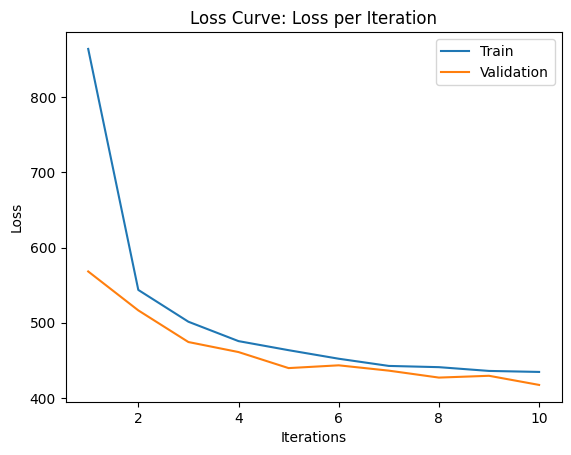

In [14]:
num_epochs = 10
checkpoint_path = '/content/gdrive/MyDrive/ConvLSTM2/checkpoints/ckpt-{}.pk'
n = 0

train_loss_list = []
val_loss_list = []
epoch_list = []

for epoch in range(1, num_epochs+1):
    
    train_loss = 0                                                 
    model.train()                                                  
    for batch_num, (input, target) in enumerate(train_loader, 1):
        n+=1  
        output = model(input)                                     
        loss = criterion(output.flatten(), target.flatten())       
        loss.backward()                                            
        optim.step()                                               
        optim.zero_grad()                                           
        train_loss += loss.item()
        torch.save(model.state_dict(), checkpoint_path.format(n))                                
    train_loss /= len(train_loader.dataset)                       

    val_loss = 0                                                 
    model.eval()                                                   
    with torch.no_grad():                                          
        for input, target in val_loader:                          
            output = model(input)                                   
            loss = criterion(output.flatten(), target.flatten())   
            val_loss += loss.item()                                
    val_loss /= len(val_loader.dataset)  

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    epoch_list.append(epoch)                          

    print("Epoch:{} Training Loss:{:.2f} Validation Loss:{:.2f}\n".format(
        epoch, train_loss, val_loss))
    
plot_curves(epoch_list, train_loss_list, val_loss_list)

In [15]:
def collate_test(batch):
    # Last 10 frames are target
    target = np.array(batch)[:,10:]                     
    
    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)          
    batch = batch / 255.0                             
    batch = batch.to(device)                          
    return batch, target

# Test Data Loader
test_loader = DataLoader(test_data,shuffle=True, 
                         batch_size=3, collate_fn=collate_test)

# Get a batch
batch, target = next(iter(test_loader))

# Initialize output sequence
output = np.zeros(target.shape, dtype=np.uint8)

# Loop over timesteps
for timestep in range(target.shape[1]):
  input = batch[:,:,timestep:timestep+10]   
  output[:,timestep]=(model(input).squeeze(1).cpu()>0.5)*255.0

In [16]:
for tgt, out in zip(target, output):       # Loop over samples
    
    # Write target video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, tgt, "GIF", fps = 5)    
        target_gif = gif.getvalue()

    # Write output video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, out, "GIF", fps = 5)    
        output_gif = gif.getvalue()

    display(HBox([widgets.Image(value=target_gif), 
                  widgets.Image(value=output_gif)]))